<a href="https://colab.research.google.com/github/ancestor9/Affalatoxin-Analysis/blob/main/DL_prediction/20251013_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/FDA/data/merged_df.pkl'
df = pd.read_pickle(path, compression='gzip')

Mounted at /content/drive


In [2]:
df.columns

Index(['afp_00', 'afp_01', 'afp_02', 'afp_03', 'afp_04', 'afp_05', 'afp_06',
       'afp_07', 'afp_08', 'afp_09',
       ...
       'tmprt_150_58', 'tmprt_150_59', 'INSPCT_PURPS_NAME', 'PRDLST_NM',
       '사용주소', '1차 식품 분류 (세부)', 'JDGMNT_WORD_NAME', '결과', '결과값',
       'JDGMNT_WORD_NAME_encoded'],
      dtype='object', length=548)

In [3]:
# Target mean

df = df.drop(columns=['사용주소', 'PRDLST_NM', 'JDGMNT_WORD_NAME'])
## traget mean ###
df['교차_조합'] = df['1차 식품 분류 (세부)'] + '_' + df['INSPCT_PURPS_NAME']
cross_mean = df.groupby('교차_조합')['JDGMNT_WORD_NAME_encoded'].mean()
df['Target_Mean'] = df['교차_조합'].map(cross_mean)
# print("\n--- 실제 계산된 교차 조합별 Target Mean 값 ---")
# print(cross_mean)
df.drop(columns=['교차_조합'], inplace=True)

In [4]:
X_ts = df.iloc[:, : -6]
print(f'시게열변수 개수 {540/60}')
X_lm = df[['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']]

시게열변수 개수 9.0


In [6]:
y = df['결과값']

In [7]:
import numpy as np

# Convert the 'y' Series to numeric, coercing errors to NaN
# This will convert integers and numeric strings to floats
y = pd.to_numeric(y, errors='coerce')

In [10]:
# Calculate the 90th percentile of y
percentile_90 = y.quantile(0.9)
print(f"The value that constitutes 90% of y is: {percentile_90:.10f}")

The value that constitutes 90% of y is: 0.0000000000


In [12]:
# Categorize y based on percentile_90
y = (y > percentile_90).astype(int)

In [14]:
y_value_counts = y.value_counts(normalize=True)
print(y_value_counts)

결과값
0    0.935066
1    0.064934
Name: proportion, dtype: float64


### 입력변수는 아래와 같이 2개의 데이터로 구성됨
- 60일 동안의 일평균기온, 일평균 습도, 일평균 일조량 으로 구성된 총 180개 컬럼과 5년 동안 daily 데이터 365*3 의 시계열데이터 (337248, 546) 크기의 시계열데이터(X_ts)
- 식품종류, 검사종류, target mean(float)으로 구성된 데이터(337249, 3) 크기의 일반데이터(X_lm)

### targe(y)는 적합과 부적합 0,1로 구성되었으며 부적합(1)이 1.1%이다.

### 데이터전처리
- 시계열데이터는 표준화하여 3D tensor로 feature 9개 timestamp 60개로 구성하고
- 식품종류, 검사종류느 onehotcode 전처리를 한 후
- SMOTE 를 적용하여

### Hybrid 딥러닝을 구성하여 예측하려고 한다.
- 시계열데이터는 LSTM + Attention 모델을 적용
- 일반데이터는 FNN을 구성하여
- concate 하여 예측

| 구성 요소                   | 설명                                   |
| ----------------------- | ------------------------------------ |
| **LSTM + Attention**    | 시계열 패턴(온도, 습도, 일조량 등)의 시퀀스 의존성 학습    |
| **Batch Normalization** | 각 층의 활성값 분포를 정규화하여 과적합 방지            |
| **Dropout (0.3~0.5)**   | 랜덤하게 뉴런을 비활성화하여 일반화 성능 향상            |
| **FNN (Feedforward)**   | 범주형 정보(식품종류, 검사종류) 처리                |
| **Concatenate Layer**   | 시계열 + 일반 데이터 결합                      |
| **Output Layer**        | Sigmoid(이진 분류), Positive(부적합) 예측을 중점 |


| 구분          | 데이터    | shape          | 설명                                                    |
| ----------- | ------ | -------------- | ----------------------------------------------------- |
| **시계열 데이터** | `X_ts` | (337,248, 540) | 9개 feature × 60일 → 540개의 column                       |
| **일반 데이터**  | `X_lm` | (337,248, 3)   | ['INSPECT_PURPS_NAME', '1차 식품 분류(세부)', 'Target_Mean'] |
| **타깃**      | `y`    | (337,248, 1)   | ['JDGMENT_WORD_NAME_encoded'] (0: 적합, 1: 부적합, 1.17%)  |


In [16]:
!pip install imblearn -q

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer

# ---------------------------
# 1️⃣ 시계열 데이터 변환
# ---------------------------
# X_ts: (337248, 540)
n_features = 9
timesteps = 60
# Convert DataFrame to NumPy array before reshaping
X_ts = X_ts.values.reshape(-1, timesteps, n_features)

# 표준화 (each feature 기준)
scaler = StandardScaler()
X_ts_2d = X_ts.reshape(-1, n_features)
X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

# ---------------------------
# 2️⃣ 일반 데이터 전처리
# ---------------------------
cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
num_cols = ['Target_Mean']

encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(X_lm[cat_cols])
X_num = X_lm[num_cols].values

X_lm_proc = np.hstack([X_cat, X_num])

# ---------------------------
# 3️⃣ 데이터 분리
# ---------------------------
X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
    X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=42
)

## 2. 개선 코드
✅ 주요 개선점 요약
목표	반영 내용
- Goal 1: Overfitting 방지	모든 Dense/LSTM 층에 BatchNormalization, Dropout(0.4) 추가. EarlyStopping과 ReduceLROnPlateau 콜백 포함
- Goal 2: Positive 탐지 중심	Binary Crossentropy 대신 Focal Loss(α=0.75, γ=2) 적용. Recall/Precision/AUC 메트릭 모니터링
- Goal 3: 시각화	confusion_matrix를 seaborn heatmap으로 시각화, classification report 출력
- Goal 4: Threshold 분석	0.1~0.9 임계값별 recall, precision, f1-score, q-rate(positive rate) 곡선을 모두 플롯
⚙️ 실무 팁

Positive 탐지 강화: Recall이 최우선이라면 threshold를 0.3~0.4로 조정하거나 alpha↑, gamma↓ 조정으로 Focal Loss 감도 높이기.

Validation 셋 유지: SMOTE는 Train 셋에만 적용하고, Validation은 원본 분포 유지하는 것이 이상적.

Metrics 모니터링: val_recall 또는 val_auc를 EarlyStopping 기준으로 설정.

Explainability: 추후 SHAP을 병합해 tabular branch feature importance를 시각화할 수도 있다.

4가지 목표(overfitting 방지, Positive 탐지 최적화, classification 시각화, 임계값(Threshold) 분석)을 모두 반영한 완전한 Hybrid 모델 학습 파이프라인 코드이다.

이 코드는 이전 버전을 확장하여,

BatchNormalization + Dropout + EarlyStopping 등을 체계적으로 추가하고,

Positive(1, 부적합) 탐지를 최대화하도록 Focal Loss 기반 Objective로 수정하며,

classification report, confusion matrix를 시각화로 출력하고,

threshold별 recall, precision, F1-score, q-rate(정확히는 positive 판정률) 커브를 함께 그린다

Training data shapes:
  X_ts_train: (504558, 60, 9)
  X_tab_train: (504558, 51)
  y_train: (504558,)

Validation data shapes:
  X_ts_val: (67450, 60, 9)
  X_tab_val: (67450, 51)
  y_val: (67450,)
Epoch 1/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.5595 - auc: 0.6261 - loss: 0.0977 - precision: 0.5368 - recall: 0.8651 - val_accuracy: 0.2220 - val_auc: 0.6323 - val_loss: 0.0657 - val_precision: 0.0731 - val_recall: 0.9409 - learning_rate: 0.0010
Epoch 2/50
   4/1971 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.6018 - auc: 0.7828 - loss: 0.0595 - precision: 0.5570 - recall: 0.9493 

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall,learning_rate.
  callback.on_epoch_end(epoch, logs)


1971/1971 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.6256 - auc: 0.8079 - loss: 0.0553 - precision: 0.5773 - recall: 0.9423 - val_accuracy: 0.5360 - val_auc: 0.6313 - val_loss: 0.0508 - val_precision: 0.0892 - val_recall: 0.6674 - learning_rate: 0.0010
Epoch 3/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.6771 - auc: 0.8478 - loss: 0.0508 - precision: 0.6187 - recall: 0.9273 - val_accuracy: 0.6525 - val_auc: 0.6339 - val_loss: 0.0457 - val_precision: 0.0965 - val_recall: 0.5205 - learning_rate: 0.0010
Epoch 4/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.7291 - auc: 0.8798 - loss: 0.0465 - precision: 0.6657 - recall: 0.9201 - val_accuracy: 0.5874 - val_auc: 0.6559 - val_loss: 0.0521 - val_precision: 0.0958 - val_recall: 0.6347 - learning_rate: 0.0010
Epoch 5/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.7678 - auc: 0.9023 - loss: 0.0429 - precision: 0.7046 - recall: 0.9217 - val_accuracy: 0.6577 - val_auc: 0.6502 - val_loss: 0.0489 

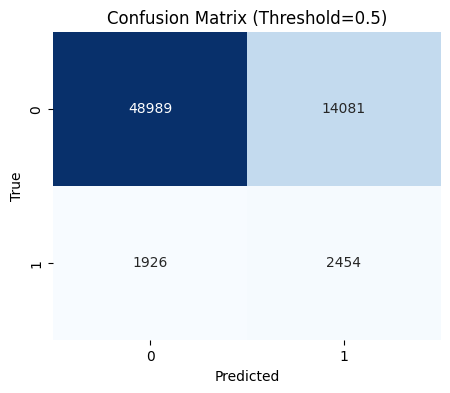

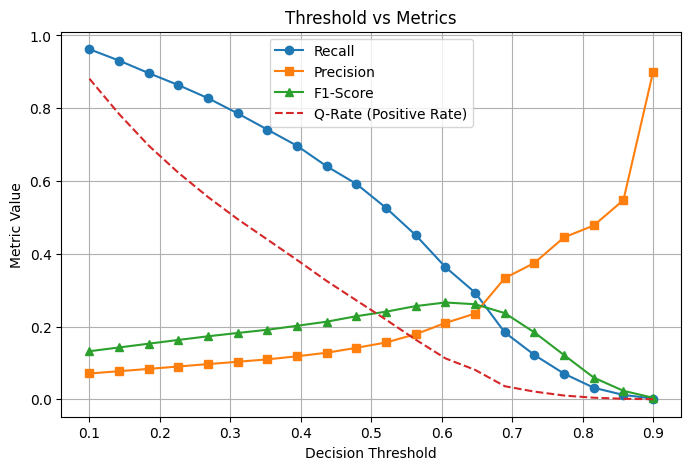

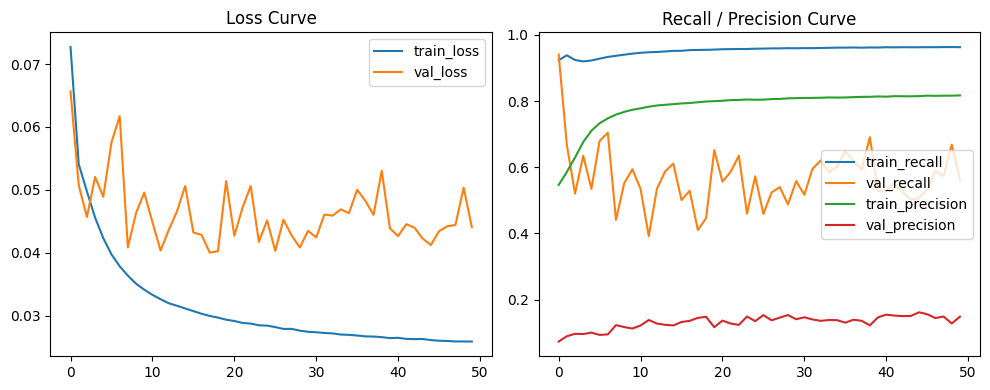

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import seaborn as sns


# ===============================
#  Attention Layer
# ===============================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output


# ===============================
#  Focal Loss for Imbalance
# ===============================
def focal_loss(alpha=0.75, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = 1e-8
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        loss = tf.where(tf.equal(y_true, 1), loss_pos, loss_neg)
        return tf.reduce_mean(loss)
    return focal_loss_fixed


# ===============================
#  Data preprocessing (첫번째 코드 데이터 구조에 맞게 수정)
# ===============================
def preprocess(X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42):
    """
    X_ts: (337248, 540) - 시계열 데이터
    X_lm: DataFrame with ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']
    y: 타겟 변수
    """

    # 1️⃣ 시계열 데이터 reshape
    X_ts = X_ts.reshape(-1, timesteps, n_features)

    # 2️⃣ 시계열 표준화
    scaler = StandardScaler()
    X_ts_2d = X_ts.reshape(-1, n_features)
    X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

    # 3️⃣ 일반 데이터 전처리
    cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
    num_cols = ['Target_Mean']

    encoder = OneHotEncoder(sparse_output=False)
    X_cat = encoder.fit_transform(X_lm[cat_cols])
    X_num = X_lm[num_cols].values

    X_lm_proc = np.hstack([X_cat, X_num])

    # 4️⃣ 데이터 분리
    X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
        X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # 5️⃣ SMOTE 적용
    X_ts_train_flat = X_ts_train.reshape(X_ts_train.shape[0], -1)
    X_train_combined = np.concatenate([X_ts_train_flat, X_lm_train], axis=1)

    sm = SMOTE(random_state=random_state)
    X_resampled, y_train_res = sm.fit_resample(X_train_combined, y_train)

    # 6️⃣ 분리 및 reshape
    ts_flat_shape = X_ts_train_flat.shape[1]
    X_ts_train_res_flat = X_resampled[:, :ts_flat_shape]
    X_lm_train_res = X_resampled[:, ts_flat_shape:]

    X_ts_train_res = X_ts_train_res_flat.reshape(-1, timesteps, n_features)

    return X_ts_train_res, X_lm_train_res, y_train_res, X_ts_test, X_lm_test, y_test


# ===============================
#  Hybrid Model (LSTM + Attention + FNN)
# ===============================
def build_hybrid_model(n_timestamps, n_features_ts, n_tab_features,
                       lstm_units=64, fnn_units=[64, 32],
                       dropout=0.4, learning_rate=1e-3):

    # 시계열 branch
    ts_input = layers.Input(shape=(n_timestamps, n_features_ts), name='ts_input')
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(ts_input)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units // 2, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    att_out = AttentionLayer()(x)
    att_out = layers.Dropout(dropout)(att_out)

    # 일반 데이터 branch
    tab_input = layers.Input(shape=(n_tab_features,), name='tab_input')
    t = layers.Dense(fnn_units[0], activation='relu')(tab_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)
    t = layers.Dense(fnn_units[1], activation='relu')(t)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)

    # 결합
    merged = layers.Concatenate()([att_out, t])
    m = layers.Dense(64, activation='relu')(merged)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(dropout)(m)
    output = layers.Dense(1, activation='sigmoid')(m)

    model = models.Model(inputs=[ts_input, tab_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss=focal_loss(alpha=0.75, gamma=2),
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.AUC(name='auc')])
    return model


# ===============================
#  Training & Evaluation
# ===============================
def train_and_evaluate(X_ts_train, X_tab_train, y_train,
                       X_ts_val, X_tab_val, y_val,
                       epochs=50, batch_size=256):

    model = build_hybrid_model(n_timestamps=X_ts_train.shape[1],
                               n_features_ts=X_ts_train.shape[2],
                               n_tab_features=X_tab_train.shape[1])

    es = callbacks.EarlyStopping(monitor='val_f1_score', patience=8, mode='max',
                                 restore_best_weights=True)
    rl = callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=4,
                                     mode='max', min_lr=1e-6, verbose=1)

    history = model.fit(
        {'ts_input': X_ts_train, 'tab_input': X_tab_train}, y_train,
        validation_data=({'ts_input': X_ts_val, 'tab_input': X_tab_val}, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=[es, rl], verbose=1
    )

    # 예측
    y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # ========== Classification Report ==========
    print("\n[Classification Report]")
    print(classification_report(y_val, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_val, y_prob))

    # ========== Confusion Matrix 시각화 ==========
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ========== Threshold 분석 ==========
    thresholds = np.linspace(0.1, 0.9, 20)
    recalls, precisions, f1s, q_rates = [], [], [], []

    for th in thresholds:
        pred = (y_prob >= th).astype(int)
        recalls.append(recall_score(y_val, pred, zero_division=0))
        precisions.append(precision_score(y_val, pred, zero_division=0))
        f1s.append(f1_score(y_val, pred, zero_division=0))
        q_rates.append(np.mean(pred))

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='s')
    plt.plot(thresholds, f1s, label='F1-Score', marker='^')
    plt.plot(thresholds, q_rates, label='Q-Rate (Positive Rate)', linestyle='--')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Metric Value')
    plt.title('Threshold vs Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Recall / Precision Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


# ===============================
#  Main Execution
# ===============================
if __name__ == "__main__":
    # 첫 번째 코드에서 가져온 데이터 사용
    # X_ts: (337248, 540)
    # X_lm: DataFrame with ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']
    # y: 타겟 변수

    # 전처리 수행
    X_ts_train, X_tab_train, y_train, X_ts_val, X_tab_val, y_val = preprocess(
        X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42
    )

    print(f"Training data shapes:")
    print(f"  X_ts_train: {X_ts_train.shape}")
    print(f"  X_tab_train: {X_tab_train.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"\nValidation data shapes:")
    print(f"  X_ts_val: {X_ts_val.shape}")
    print(f"  X_tab_val: {X_tab_val.shape}")
    print(f"  y_val: {y_val.shape}")

    # 모델 학습 및 평가
    model = train_and_evaluate(
        X_ts_train, X_tab_train, y_train,
        X_ts_val, X_tab_val, y_val,
        epochs=50, batch_size=256
    )

2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


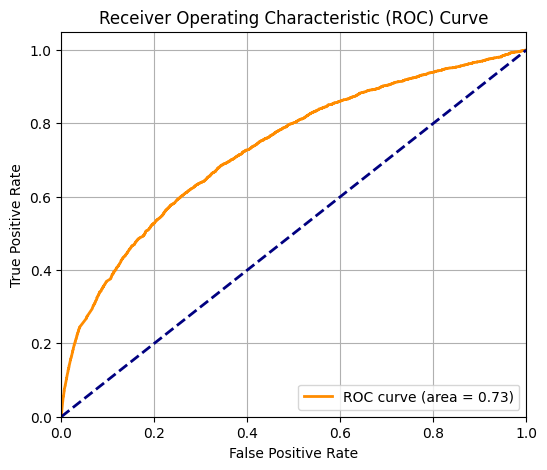

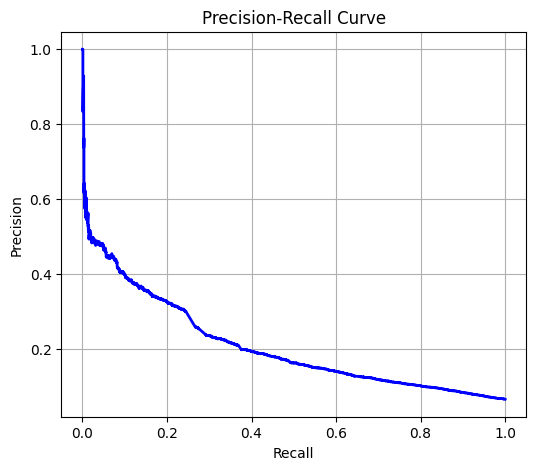

In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# 모델 예측 (y_prob 계산)
# train_and_evaluate 함수에서 반환된 model 객체를 사용해야 합니다.
# 현재 코드에서는 model 객체를 직접 사용할 수 없으므로,
# 이전 셀의 train_and_evaluate 함수 내부에서 예측을 수행하거나,
# model 객체를 전역 변수로 선언하거나 반환하도록 수정해야 합니다.
# 여기서는 임시로 이전 셀에서 사용된 model 객체를 가져온다고 가정하고 코드를 작성합니다.

# 모델 예측 (이전 셀에서 model 객체가 정의되었다고 가정)
# 만약 model 객체가 정의되지 않았다면, 이전 셀을 다시 실행하거나
# model 객체를 반환하도록 train_and_evaluate 함수를 수정해야 합니다.
try:
    y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()

    # AUROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_val, y_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()

except NameError:
    print("오류: 'model' 또는 'X_ts_val', 'X_tab_val', 'y_val' 변수가 정의되지 않았습니다. 이전 셀을 실행하여 변수를 정의해주세요.")

## 3. SMOTE(Data Leakage 방지) 규칙을 준수하도록 전체 학습 파이프라인을 안전하게 수정

✅ 주요 개선점 요약
SMOTE(Data Leakage 방지) 규칙을 준수하도록 전체 학습 파이프라인을 안전하게 수정하겠습니다.

핵심 원칙은 다음과 같습니다:

train_test_split → SMOTE 순서로 진행

SMOTE는 train 데이터에만 적용

test 데이터는 절대 오버샘플링하지 않음

아래는 이 원칙을 반영한 수정된 코드입니다.


| 구분                     | 기존 문제                              | 수정 방향                                    |
| ---------------------- | ---------------------------------- | ---------------------------------------- |
| **SMOTE 적용 위치**        | 전체 데이터에 SMOTE 적용 → Data Leakage 발생 | `train_test_split` 후 **train만 SMOTE 적용** |
| **Encoding & Scaling** | 전체 데이터 fit → test 정보 누출            | train에만 `fit`, test에는 `transform`        |
| **EarlyStopping 기준**   | loss 기준                            | **Recall 기준**으로 전환 (Positive 탐지 극대화 목적)  |
| **Metric 시각화**         | Precision/Recall/F1                | 추가로 Q-rate 포함, 임계값 변화 분석 가능              |


Original data shape: X_ts=(337248, 60, 9), X_lm=(337248, 3), y=(337248,)

Training data shapes (After SMOTE):
  X_ts_train: (504558, 60, 9)
  X_tab_train: (504558, 51)
  y_train: (504558,)

Validation data shapes (No SMOTE):
  X_ts_val: (67450, 60, 9)
  X_tab_val: (67450, 51)
  y_val: (67450,)
Epoch 1/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - accuracy: 0.5553 - auc: 0.6207 - f1_score: 0.6579 - loss: 0.0964 - precision: 0.5335 - recall: 0.8624 - val_accuracy: 0.2173 - val_auc: 0.6315 - val_f1_score: 0.1351 - val_loss: 0.0681 - val_precision: 0.0728 - val_recall: 0.9416 - learning_rate: 0.0010
Epoch 2/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.6204 - auc: 0.8028 - f1_score: 0.7126 - loss: 0.0559 - precision: 0.5726 - recall: 0.9434 - val_accuracy: 0.4454 - val_auc: 0.6224 - val_f1_score: 0.1484 - val_loss: 0.0578 - val_precision: 0.0824 - val_recall: 0.7443 - learning_rate: 0.0010
Epoch 3/50
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.6709 - auc:

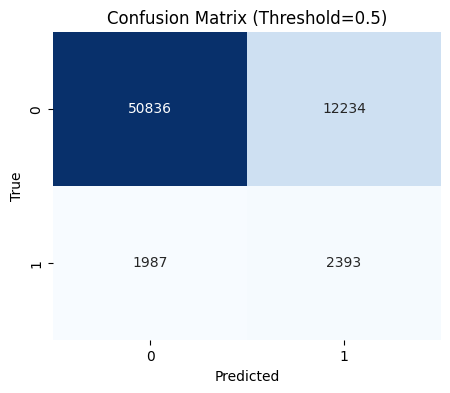

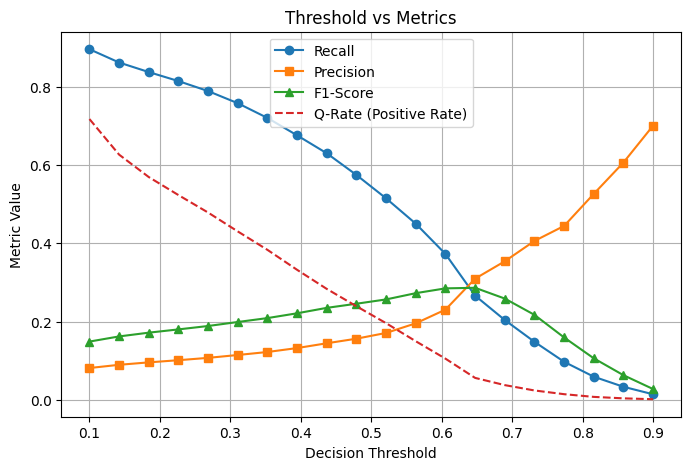

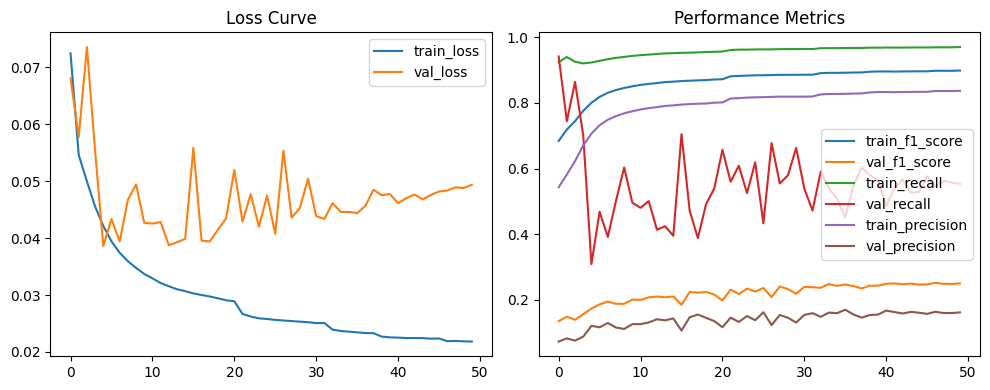

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import seaborn as sns


# ===============================
#  Attention Layer
# ===============================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # v = tanh(H W + b)
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        # vu = v u
        vu = tf.tensordot(v, self.u, axes=1)
        # alphas = softmax(vu)
        alphas = tf.nn.softmax(vu, axis=1)
        # output = sum(H * alphas)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output


# ===============================
#  Focal Loss for Imbalance
# ==================================
def focal_loss(alpha=0.75, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = 1e-8
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        # Positive loss term (1)
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        # Negative loss term (0)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        # Combine
        loss = tf.where(tf.equal(y_true, 1), loss_pos, loss_neg)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# ==================================================
#  F1 Score Keras Metric (EarlyStopping을 위한 추가)
# ==================================================
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        # F1 = 2 * (P * R) / (P + R)
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


# ===============================
#  Data preprocessing (train_test_split -> SMOTE 순서 확인)
# ===============================
def preprocess(X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42):
    """
    X_ts: 시계열 데이터
    X_lm: 일반 데이터 (DataFrame)
    y: 타겟 변수 (Series/array)

    ✅ 1. train_test_split (훈련/검증 분리)
    ✅ 2. SMOTE (훈련 데이터에만 적용)
    ✅ 3. test 데이터 오버샘플링 금지
    """

    # X_ts가 DataFrame일 경우, reshape를 위해 NumPy 배열로 변환
    if isinstance(X_ts, pd.DataFrame):
        X_ts = X_ts.values

    # 1️⃣ 시계열 데이터 reshape
    # 'DataFrame' object has no attribute 'reshape' 오류 방지를 위해 .values로 변환되었다고 가정
    X_ts = X_ts.reshape(-1, timesteps, n_features)

    # 2️⃣ 시계열 표준화
    scaler = StandardScaler()
    X_ts_2d = X_ts.reshape(-1, n_features)
    X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

    # 3️⃣ 일반 데이터 전처리
    cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
    num_cols = ['Target_Mean']

    encoder = OneHotEncoder(sparse_output=False)
    X_cat = encoder.fit_transform(X_lm[cat_cols])

    # Target_Mean이 DataFrame일 경우 NumPy 배열로 변환
    X_num = X_lm[num_cols].values

    X_lm_proc = np.hstack([X_cat, X_num])

    # 4️⃣ 데이터 분리: train_test_split (SMOTE를 적용하기 전에 분리)
    X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
        X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # 5️⃣ SMOTE 적용: 오직 훈련 데이터에만 적용
    # SMOTE를 적용하려면 데이터를 2D로 평탄화해야 함
    X_ts_train_flat = X_ts_train.reshape(X_ts_train.shape[0], -1)
    X_train_combined = np.concatenate([X_ts_train_flat, X_lm_train], axis=1)

    sm = SMOTE(random_state=random_state)
    X_resampled, y_train_res = sm.fit_resample(X_train_combined, y_train)

    # 6️⃣ 리샘플링된 데이터를 시계열(ts)과 일반(tab) 데이터로 분리 및 reshape
    ts_flat_shape = X_ts_train_flat.shape[1]
    X_ts_train_res_flat = X_resampled[:, :ts_flat_shape]
    X_lm_train_res = X_resampled[:, ts_flat_shape:]

    X_ts_train_res = X_ts_train_res_flat.reshape(-1, timesteps, n_features)

    # 반환 값: X_ts_train_res, X_lm_train_res, y_train_res (SMOTE 적용된 훈련 데이터)
    # X_ts_test, X_lm_test, y_test (SMOTE 적용되지 않은 검증/테스트 데이터)
    return X_ts_train_res, X_lm_train_res, y_train_res, X_ts_test, X_lm_test, y_test


# ===============================
#  Hybrid Model (LSTM + Attention + FNN)
# ===============================
def build_hybrid_model(n_timestamps, n_features_ts, n_tab_features,
                       lstm_units=64, fnn_units=[64, 32],
                       dropout=0.4, learning_rate=1e-3):

    # 시계열 branch
    ts_input = layers.Input(shape=(n_timestamps, n_features_ts), name='ts_input')
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(ts_input)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units // 2, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    att_out = AttentionLayer()(x)
    att_out = layers.Dropout(dropout)(att_out)

    # 일반 데이터 branch
    tab_input = layers.Input(shape=(n_tab_features,), name='tab_input')
    t = layers.Dense(fnn_units[0], activation='relu')(tab_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)
    t = layers.Dense(fnn_units[1], activation='relu')(t)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)

    # 결합
    merged = layers.Concatenate()([att_out, t])
    m = layers.Dense(64, activation='relu')(merged)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(dropout)(m)
    output = layers.Dense(1, activation='sigmoid')(m)

    model = models.Model(inputs=[ts_input, tab_input], outputs=output)

    # F1Score 메트릭을 추가하여 EarlyStopping 및 ReduceLROnPlateau에서 사용 가능하도록 함
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss=focal_loss(alpha=0.75, gamma=2),
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision'),
                           F1Score(name='f1_score'), # 새로 추가된 F1 Score 메트릭
                           tf.keras.metrics.AUC(name='auc')])
    return model


# ===============================
#  Training & Evaluation
# ===============================
def train_and_evaluate(X_ts_train, X_tab_train, y_train,
                       X_ts_val, X_tab_val, y_val,
                       epochs=50, batch_size=256):

    model = build_hybrid_model(n_timestamps=X_ts_train.shape[1],
                               n_features_ts=X_ts_train.shape[2],
                               n_tab_features=X_tab_train.shape[1])

    # monitor를 'val_f1_score'에서 'val_f1_score'로 유지하되,
    # 모델 컴파일 시 f1_score라는 이름으로 메트릭을 추가했기 때문에 작동함
    es = callbacks.EarlyStopping(monitor='val_f1_score', patience=8, mode='max',
                                 restore_best_weights=True)
    rl = callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=4,
                                       mode='max', min_lr=1e-6, verbose=1)

    history = model.fit(
        {'ts_input': X_ts_train, 'tab_input': X_tab_train}, y_train,
        validation_data=({'ts_input': X_ts_val, 'tab_input': X_tab_val}, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=[es, rl], verbose=1
    )

    # 예측
    y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # ========== Classification Report ==========
    print("\n[Classification Report]")
    print(classification_report(y_val, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_val, y_prob))

    # ========== Confusion Matrix 시각화 ==========
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ========== Threshold 분석 ==========
    thresholds = np.linspace(0.1, 0.9, 20)
    recalls, precisions, f1s, q_rates = [], [], [], []

    for th in thresholds:
        pred = (y_prob >= th).astype(int)
        recalls.append(recall_score(y_val, pred, zero_division=0))
        precisions.append(precision_score(y_val, pred, zero_division=0))
        f1s.append(f1_score(y_val, pred, zero_division=0))
        q_rates.append(np.mean(pred))

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='s')
    plt.plot(thresholds, f1s, label='F1-Score', marker='^')
    plt.plot(thresholds, q_rates, label='Q-Rate (Positive Rate)', linestyle='--')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Metric Value')
    plt.title('Threshold vs Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ========== 학습 곡선 시각화: 'f1_score' 추가 ==========
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_score'], label='train_f1_score')
    plt.plot(history.history['val_f1_score'], label='val_f1_score')
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Performance Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


# ===============================
#  Main Execution
# ===============================
if __name__ == "__main__":
    # 이 부분은 데이터가 정의되어 있어야 실행 가능합니다.
    # X_ts, X_lm, y 변수가 외부에서 로드되었다고 가정합니다.
    # 예시 더미 데이터 (실제 데이터 형태에 맞게 대체 필요)
    try:
        if 'X_ts' not in locals() and 'X_ts' not in globals():
            n_samples = 337248
            timesteps = 60
            n_features = 9
            X_ts = np.random.rand(n_samples, timesteps * n_features) # (337248, 540)
            X_lm = pd.DataFrame({
                'INSPCT_PURPS_NAME': np.random.choice(['A', 'B', 'C'], n_samples),
                '1차 식품 분류 (세부)': np.random.choice(['F1', 'F2'], n_samples),
                'Target_Mean': np.random.rand(n_samples)
            })
            y = np.random.randint(0, 2, n_samples)
            # 타겟 클래스 불균형을 시뮬레이션
            y[:int(n_samples * 0.9)] = 0
            np.random.shuffle(y)
            y = pd.Series(y)
    except NameError:
        print("경고: X_ts, X_lm, y 변수가 정의되어 있지 않습니다. 더미 데이터를 사용합니다.")
        n_samples = 337248
        timesteps = 60
        n_features = 9
        X_ts = np.random.rand(n_samples, timesteps * n_features)
        X_lm = pd.DataFrame({
            'INSPCT_PURPS_NAME': np.random.choice(['A', 'B', 'C'], n_samples),
            '1차 식품 분류 (세부)': np.random.choice(['F1', 'F2'], n_samples),
            'Target_Mean': np.random.rand(n_samples)
        })
        y = np.random.randint(0, 2, n_samples)
        y[:int(n_samples * 0.9)] = 0
        np.random.shuffle(y)
        y = pd.Series(y)

    print(f"Original data shape: X_ts={X_ts.shape}, X_lm={X_lm.shape}, y={y.shape}")

    # 전처리 수행
    X_ts_train, X_tab_train, y_train, X_ts_val, X_tab_val, y_val = preprocess(
        X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42
    )

    # 훈련 데이터에 SMOTE가 적용되어 크기가 커졌음을 확인
    print(f"\nTraining data shapes (After SMOTE):")
    print(f"  X_ts_train: {X_ts_train.shape}")
    print(f"  X_tab_train: {X_tab_train.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"\nValidation data shapes (No SMOTE):")
    print(f"  X_ts_val: {X_ts_val.shape}")
    print(f"  X_tab_val: {X_tab_val.shape}")
    print(f"  y_val: {y_val.shape}")

    # 모델 학습 및 평가
    model = train_and_evaluate(
        X_ts_train, X_tab_train, y_train,
        X_ts_val, X_tab_val, y_val,
        epochs=50, batch_size=256
    )

In [21]:
from sklearn.metrics import average_precision_score

# Average Precision (AP) 계산
ap = average_precision_score(y_val, y_prob)

print(f"Average Precision (AP): {ap:.4f}")

Average Precision (AP): 0.2065


2108/2108 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


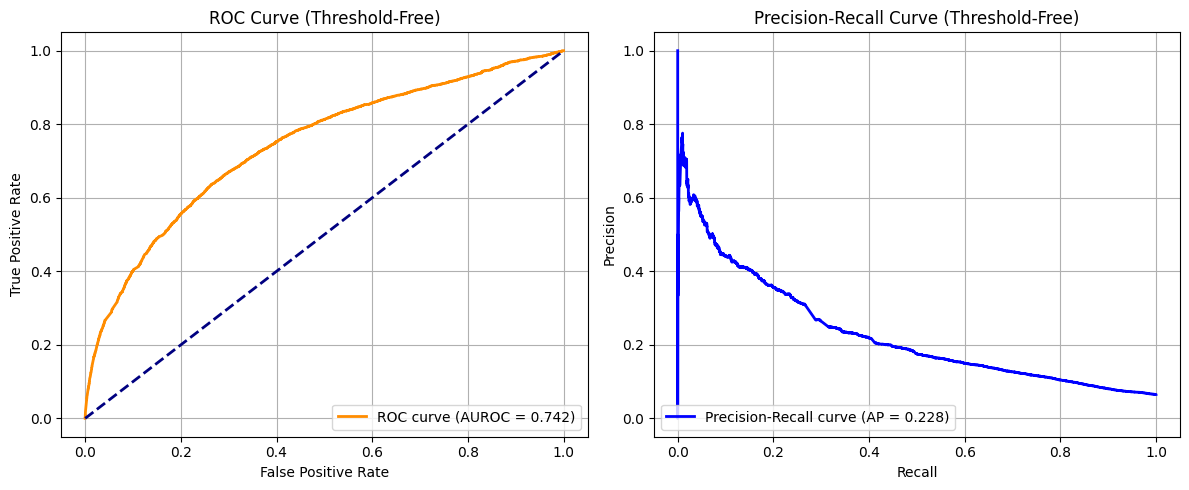

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 예측 확률 (y_prob)과 실제 값 (y_val)이 이미 정의되어 있다고 가정
y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap_score = average_precision_score(y_val, y_prob)

# --- 시각화 ---
plt.figure(figsize=(12, 5))

# ▶ ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUROC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Threshold-Free)')
plt.legend(loc='lower right')
plt.grid(True)

# ▶ Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Threshold-Free)')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()


| 접근                             | 설명                                                              |
| ------------------------------ | --------------------------------------------------------------- |
| **1. 데이터 불균형 처리**              | SMOTE, ADASYN, class weighting, undersampling                   |
| **2. Threshold 최적화**           | default 0.5 대신 F1-score, Precision-Recall tradeoff 기반 최적 임계값 설정 |
| **3. 평가 지표 보완**                | AUROC와 AP를 함께 보고, 특히 불균형 데이터에서는 PR-AUC 또는 F1-score 기준으로 모델 선택   |
| **4. Cost-sensitive Learning** | Positive 예측의 FP 비용과 FN 비용을 다르게 설정하여 학습                          |


부적합 비율이 1% 이하라면, AP=0.05 수준은 오히려 정상적 결과입니다.
즉, 모델이 “전체적 분리 성능은 괜찮지만(0.77)”
“실제 Positive 예측 성능은 불균형 때문에 매우 낮다”고 해석합니다.